# Use `GemPy` to create a geological model as input to `emg3d`

A simple example how you can use [GemPy](https://www.gempy.org) to create a geological model, move it onto [discretize](http://discretize.simpeg.xyz), and calculate CSEM data with [emg3d](https://empymod.github.io). Having it in discretize allows us to plot it in VTK directly in the notebook using [PyVista](https://github.com/pyvista)

### Requires
- emg3d, discretize, gempy, pyvista
- numpy, numba, matplotlib, panel

`panel` is only required to show the VTK-plot directly inside the notebook. `PyVista` is required for the VTK-plot.

In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

import numpy as np
import gempy as gempy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

In [2]:
import emg3d
import pyvista
import panel
import discretize


In [3]:
%matplotlib notebook
plt.style.use('ggplot')

## Creating a geological model

We start by using the model given in [Chapter 1.1](https://nbviewer.jupyter.org/github/cgre-aachen/gempy/blob/master/notebooks/tutorials/ch1-1_Basics.ipynb) of the GemPy documentation. It is a nice, made-up model of a folded structure with a fault. 

**Changes made:** We load the csv-files from the above example in Chapter 1.1. I changed the stratigraphic unit names, and moved the model 2 km down.

Instead of reading a csv-file we could initiate an empty instance and then add points and orientations after that by, e.g., providing numpy arrays.

In [4]:
# Initiate a model
geo_model = gempy.create_model('gempy-discretize-emg3d')

# Importing the data from CSV-files and setting extent and resolution
gempy.init_data(
    geo_model,
    [0,2000., 0,2000., -2000, 40.], [50, 50, 51],   # This is a regular grid, mainly for plotting purposes
    path_o = "../data/input_data/tut_chapter1/simple_fault_model_orientations_geophy.csv",
    path_i = "../data/input_data/tut_chapter1/simple_fault_model_points_geophy.csv",
)

Active grids: ['regular']


gempy-discretize-emg3d  2019-07-13 14:44

## Initiate the stratigraphies and faults, and add resistivities to lithology

In [5]:
# Add an air-layer: Horizontal layer at z=0m
geo_model.add_surfaces('air')
geo_model.add_surface_points(0, 0, 0, 'air')
geo_model.add_surface_points(0, 0, 0, 'air')
geo_model.add_orientations(0, 0, 0, 'air', [0, 0, 1])

# Add a Series for the air layer; this series will not be cut by the fault
geo_model.add_series('Air_Series')
geo_model.modify_order_series(2, 'Air_Series')
gempy.map_series_to_surfaces(geo_model, {'Air_Series': 'air'})

# Map the different series
gempy.map_series_to_surfaces(
    geo_model,
    {
        "Fault_Series": 'fault', 
        "Air_Series": ('air'),
        "Strat_Series": ('seawater', 'overburden', 'target', 'underburden', 'basement')
    },
    remove_unused_series=True
)

,surface,series,order_surfaces,isBasement,color,id
6,air,Air_Series,1,False,#325916,1
4,fault,Fault_Series,1,False,#443988,2
0,target,Strat_Series,1,False,#015482,3
1,underburden,Strat_Series,2,False,#9f0052,4
2,overburden,Strat_Series,3,False,#ffbe00,5
3,seawater,Strat_Series,4,False,#728f02,6
5,basement,Strat_Series,5,True,#ff3f20,7


In [6]:
geo_model.rename_series({'Main_Fault':'Fault_Series'})

,order_series,BottomRelation
Air_Series,1,Erosion
Fault_Series,2,Erosion
Strat_Series,3,Erosion


In [7]:
# Set which series the fault series is cutting
geo_model.set_is_fault('Fault_Series')
geo_model.faults.faults_relations_df

Fault colors changed. If you do not like this behavior, set change_color to False.


,Air_Series,Fault_Series,Strat_Series
Air_Series,False,False,False
Fault_Series,False,False,True
Strat_Series,False,False,False


## Model generation


In [8]:
gempy.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_compile',
    verbose=[]
)

Compiling theano function...
Compilation Done!


In [9]:
sol = gempy.compute_model(geo_model, compute_mesh=True)

<IPython.core.display.Javascript object>


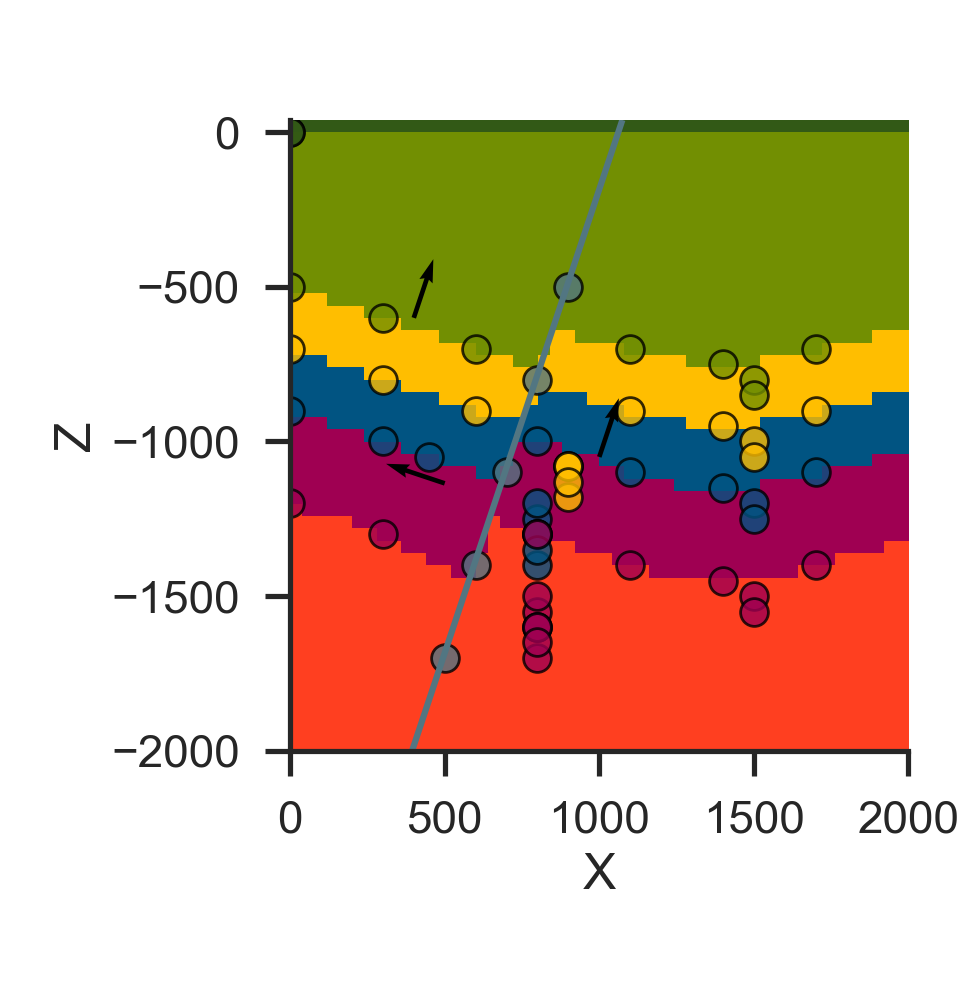

In [10]:
# Plot lithologies (colour-code corresponds to lithologies)
_ = gempy.plot.plot_section(geo_model, cell_number=25, direction='y', show_data=True)

## Let's start with a discretize mesh for a CSEM survey

Source location and frequency

In [11]:
src = [1000, 1000, -500, 0, 0]  # x-directed e-source at (1000, 1000, -500)
freq = 1.0                      # Frequency

In [12]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = emg3d.utils.get_domain(x0=src[0], freq=freq, limits=[0, 2000], min_width=[5, 100])
hz_min, zdomain = emg3d.utils.get_domain(freq=freq, limits=[-2000, 0], min_width=[5, 20], fact_pos=40)

# Create stretched grid
nx = 2**6
hx = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src[0])
hy = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src[1])
hz = emg3d.utils.get_stretched_h(hz_min, zdomain, nx*2, x0=src[2], x1=0)
grid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
grid

TensorMesh: 524,288 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     64       -378.34      2,378.34     43.07     43.07    1.00
   y     64       -378.34      2,378.34     43.07     43.07    1.00
   z    128     -2,000.00     11,334.05     20.00    531.76    1.05

### Create a smaller grid without the massive air-layer
(The massive air-layer is used to push the boundary far away for the calculation.)

In [13]:
c_nz = 70
cgrid = discretize.TensorMesh([grid.hx, grid.hy, grid.hz[:-c_nz]], x0=grid.x0)

## Put resistivities to stratigraphic units

We could define the resistivities before, but currently it is difficult for GemPy to interpolate for something like resistivities with a very wide range of values (several orders of magnitudes). So we can simply map it here to the `id` (Note: GemPy does not do interpolation for cells which lie in different stratigraphies).

In [14]:
# First, we have to get the id's for our mesh
sol = gempy.compute_model_at(grid.gridCC, geo_model)

Active grids: ['custom']


In [15]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
6,air,Air_Series,1,False,#325916,1
4,fault,Fault_Series,1,False,#527682,2
3,seawater,Strat_Series,1,False,#728f02,3
2,overburden,Strat_Series,2,False,#ffbe00,4
0,target,Strat_Series,3,False,#015482,5
1,underburden,Strat_Series,4,False,#9f0052,6
5,basement,Strat_Series,5,True,#ff3f20,7


In [16]:
# Now, we convert the id's to resistivities
res = sol[0][0, :grid.nC]

res[res == 1] = 2e14  # air
# id=2 is the fault
res[np.round(res) == 3] = 0.3  # sea water
res[np.round(res) == 4] = 1    # overburden
res[np.round(res) == 5] = 50   # target
res[np.round(res) == 6] = 1.5  # underburden
res[np.round(res) == 7] = 200  # basement

## Plot the input model

In [ ]:
dataset = grid.toVTK({'res': np.log10(res)})
dataset = dataset.clip_box(bounds=(0, 2000, 0, 2000, -2000, 0), invert=False)

# Create the rendering scene and add a grid axes
p = pyvista.Plotter(notebook=True)
p.show_grid(location='outer')

# Add spatially referenced data to the scene
dparams = {'rng': np.log10([0.3, 200]), 'cmap': 'viridis', 'show_edges': False}
xyz = (1500, 500, -1500)
p.add_mesh(dataset.slice('x', xyz), name='x-slice', **dparams)
p.add_mesh(dataset.slice('y', xyz), name='y-slice', **dparams)
#p.add_mesh(dataset.slice('z', xyz), name='z-slice', **dparams)

# Add a layer as 3D
p.add_mesh(dataset.threshold([1.69, 1.7]),  name='vol', **dparams)

# Show the scene!
p.show(use_panel=True)

## Calculate the resistivities

In [18]:
# Create model
model = emg3d.utils.Model(grid, res, freq=freq)

# Source field
sfield = emg3d.utils.get_source_field(grid, src, freq, 0)

# Calculate the efield
pfield = emg3d.solver.solver(grid, model, sfield, sslsolver=True, verb=3)


:: emg3d START :: 14:44:47 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50 (1)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  :  64 x  64 x 128     => 524,288 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   5 ;   5 ;   6   

   [hh:mm:ss]     error          solver               MG          l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [14:44:50] 2.812e-07 after                       1 F-cycles;   0 0
   [14:44:53] 4.121e-08 after                       2 F-cycles;   0 0
   [14:44:53] 2.244e-08 after  1 bicgstab-cycl

<IPython.core.display.Javascript object>


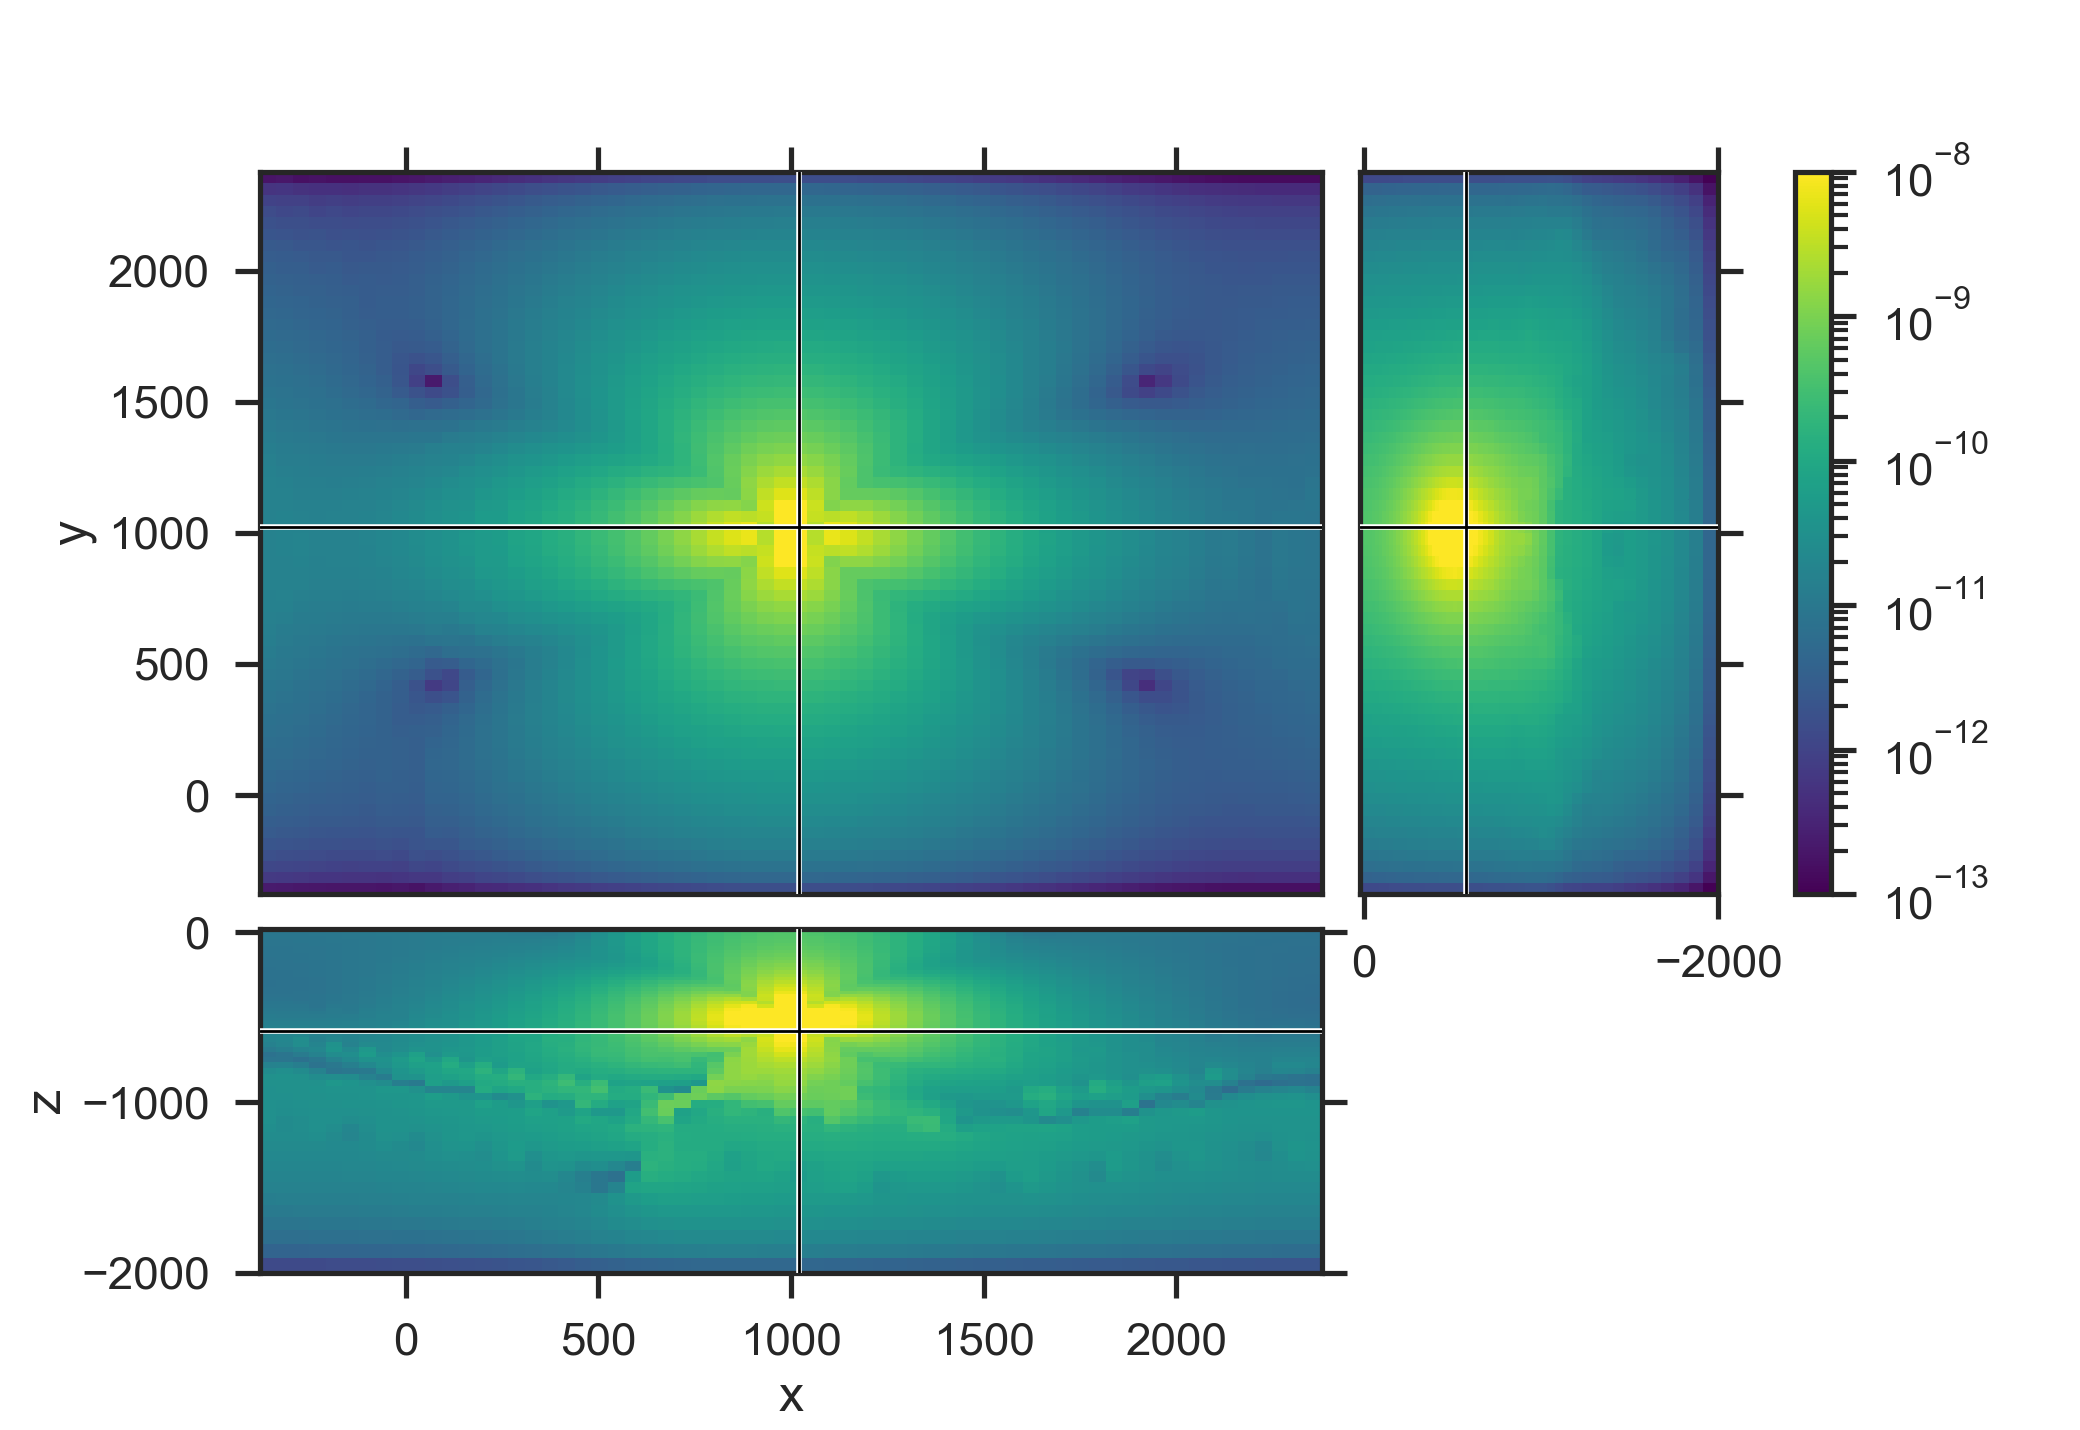

In [19]:
cgrid.plot_3d_slicer(
    pfield.fx[:, :, :-70].ravel('F'), zslice=-1000, view='abs', vType='Ex',
    clim=[1e-13, 1e-8], pcolorOpts={'cmap': 'viridis', 'norm': LogNorm()})

In [20]:
emg3d.Versions([pyvista, panel, discretize, gempy])

------------------------------------------------------
  Sat Jul 13 14:45:07 2019 CEST

         Darwin : OS
             12 : CPU(s)
         1.16.2 : numpy
          1.2.1 : scipy
         0.44.0 : numba
          0.6.2 : emg3d
          7.5.0 : IPython
          3.0.3 : matplotlib
         0.20.3 : pyvista
          0.6.0 : panel
          0.4.4 : discretize
           2.0b : gempy

  3.7.3 (default, Mar 27 2019, 16:54:48)  [Clang
  4.0.1 (tags/RELEASE_401/final)]

  Intel(R) Math Kernel Library Version 2019.0.3
  Product Build 20190125 for Intel(R) 64
  architecture applications
------------------------------------------------------